#### **Used Libraries**

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
import pickle
sns.set_style("dark")
plt.rcParams["figure.figsize"] = (5, 7)
%matplotlib inline

<hr/>

#### **Data Ingestion**

In [2]:
vistors_df = pd.read_csv(r"D:\Umrah Visitors Prediction\umrah_visitors_dataset.csv")

<hr/>

#### **Exploring Data & Cleaning**

`• Data Overview`

In [3]:
vistors_df.head()

,Visitor_ID,Month,Nationality,Age,Umrah_Type,Stay_Duration,Visa_Type,Accommodation_Type,Transportation_Mode,Spending
0,1,September,Indian,70.0,Group,14.0,Umrah Visa,Hotel,Taxi,5000.000000
1,2,May,Sudanese,28.9,Group,3.0,Umrah Visa,Hotel,Bus,2817.178967
2,3,October,Sudanese,45.8,Group,8.0,Umrah Visa,Apartment,Private Car,3655.795713
3,4,May,Pakistani,66.9,Individual,13.0,Umrah Visa,Hotel,Private Car,4451.848412
4,5,November,Jordanian,44.3,Individual,6.0,Umrah Visa,Hotel,Taxi,3296.688625


In [4]:
vistors_df.tail(3)

,Visitor_ID,Month,Nationality,Age,Umrah_Type,Stay_Duration,Visa_Type,Accommodation_Type,Transportation_Mode,Spending
100297,29677,July,Turkish,70.0,Group,13.0,Umrah Visa,Apartment,Bus,5000.000000
100298,6281,February,Turkish,37.5,Group,8.0,Umrah Visa,Hotel,Bus,3534.178967
100299,25668,February,Jordanian,70.0,Individual,19.0,Umrah Visa,Hotel,Bus,5000.000000


In [5]:
vistors_df.columns

Index(['Visitor_ID', 'Month', 'Nationality', 'Age', 'Umrah_Type',
       'Stay_Duration', 'Visa_Type', 'Accommodation_Type',
       'Transportation_Mode', 'Spending'],
      dtype='object')

In [6]:
len(vistors_df.columns)

10

In [7]:
vistors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100300 entries, 0 to 100299
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Visitor_ID           100300 non-null  int64  
 1   Month                100300 non-null  object 
 2   Nationality          100300 non-null  object 
 3   Age                  98298 non-null   float64
 4   Umrah_Type           100300 non-null  object 
 5   Stay_Duration        98298 non-null   float64
 6   Visa_Type            100300 non-null  object 
 7   Accommodation_Type   100300 non-null  object 
 8   Transportation_Mode  100300 non-null  object 
 9   Spending             98298 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 7.7+ MB


In [8]:
round(vistors_df.describe(), 3)

,Visitor_ID,Age,Stay_Duration,Spending
count,100300.000,98298.000,98298.000,98298.000
mean,50001.579,56.516,11.995,4301.952
std,28870.852,14.290,5.550,845.238
min,1.000,20.000,1.000,2000.000
25%,24999.750,44.300,7.000,3641.128
50%,50006.500,61.200,12.000,4771.179
75%,75003.250,70.000,16.000,5000.000
max,100000.000,70.000,28.000,5000.000


In [9]:
vistors_df.describe(include = "O")

,Month,Nationality,Umrah_Type,Visa_Type,Accommodation_Type,Transportation_Mode
count,100300,100300,100300,100300,100300,100300
unique,12,7,2,3,3,4
top,December,Indian,Individual,Umrah Visa,Hotel,Bus
freq,14975,14459,60179,70015,70191,39997


`• Checking & Dealing With Nulls - Duplicated Values`

In [10]:
vistors_df.isnull().sum().sort_values(ascending = False)

Age                    2002
Stay_Duration          2002
Spending               2002
Visitor_ID                0
Month                     0
Nationality               0
Umrah_Type                0
Visa_Type                 0
Accommodation_Type        0
Transportation_Mode       0
dtype: int64

In [11]:
# Around ( 2% Nulls ) And Our Data Is Normal Distriburion, So We Will Fill With Mean.
for col in vistors_df.columns :
    if vistors_df[col].dtype == 'O' :
        vistors_df[col].fillna(vistors_df[col].mode()[0], inplace = True)
    else :
        vistors_df[col].fillna(vistors_df[col].mean(), inplace = True)

In [12]:
vistors_df.isnull().sum()

Visitor_ID             0
Month                  0
Nationality            0
Age                    0
Umrah_Type             0
Stay_Duration          0
Visa_Type              0
Accommodation_Type     0
Transportation_Mode    0
Spending               0
dtype: int64

In [13]:
vistors_df.duplicated().sum()

2

In [14]:
vistors_df['Visitor_ID'].duplicated().sum()

300

In [15]:
# Check For The Same Vistors
vistors_df[vistors_df.duplicated(subset=['Visitor_ID'], keep=False)].sort_values(by='Visitor_ID').head(6)

,Visitor_ID,Month,Nationality,Age,Umrah_Type,Stay_Duration,Visa_Type,Accommodation_Type,Transportation_Mode,Spending
157,158,April,Egyptian,52.4,Individual,13.0,Umrah Visa,Hotel,Bus,4264.178967
100087,158,June,Egyptian,48.5,Individual,7.0,Umrah Visa,Hotel,Bus,4264.178967
866,867,November,Indian,70.0,Individual,21.0,Umrah Visa,Hotel,Taxi,5000.000000
100149,867,April,Indian,70.0,Individual,19.0,Umrah Visa,Hotel,Taxi,5000.000000
955,956,January,Jordanian,65.3,Individual,11.0,Umrah Visa,Hotel,Bus,4997.178967
100286,956,February,Jordanian,59.0,Individual,11.0,Umrah Visa,Hotel,Bus,4997.178967


In [16]:
# Drop The Same Customers As It Appear As Not Logically Correct ( The Spent The Same But In Different Month )
vistors_df.drop_duplicates(subset = ['Visitor_ID'], inplace = True)

In [17]:
# Deplicates Can Bais The Model During Training. So, We Will Remove Them.
vistors_df.drop_duplicates(inplace = True)
print(vistors_df.duplicated().sum())

0


In [18]:
# Check For Inconsistent or Misspelled Categories
for col in vistors_df.select_dtypes(exclude = 'number') :
    print(vistors_df[col].unique())
    print(" " * 10)

['September' 'May' 'October' 'November' 'December' 'January' 'June'
 'February' 'March' 'April' 'August' 'July']
          
['Indian' 'Sudanese' 'Pakistani' 'Jordanian' 'Turkish' 'Egyptian'
 'Indonesian']
          
['Group' 'Individual']
          
['Umrah Visa' 'Tourist Visa' 'Work Visa']
          
['Hotel' 'Apartment' "Relative's House"]
          
['Taxi' 'Bus' 'Private Car' 'On Foot']
          


In [19]:
# Check For Logicall Errors
len(vistors_df[vistors_df['Age'] < 1])

0

`• Analyzing Features Distribution`

In [20]:
numeric_columns = vistors_df.select_dtypes(include = "number").columns
categorical_columns = vistors_df.select_dtypes(exclude = "number").columns

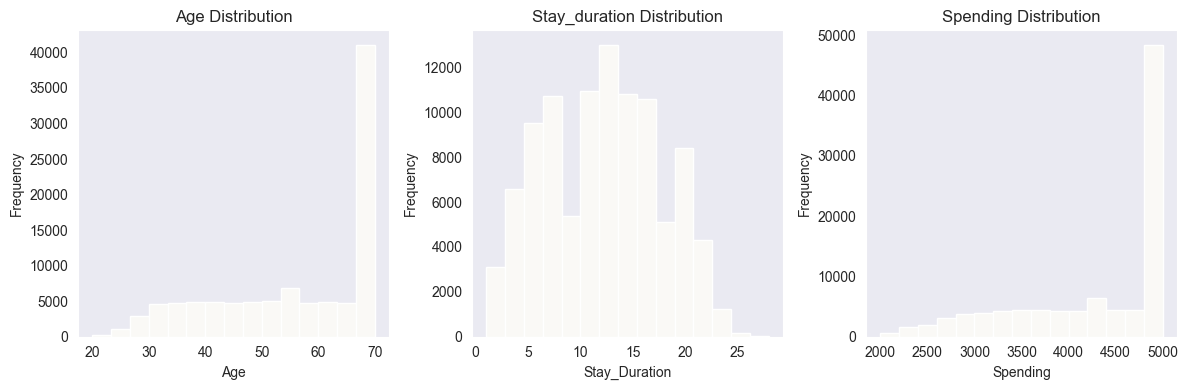

In [21]:
filtered_numeric_columns = [col for col in numeric_columns if col != "Visitor_ID"]
n_cols = 3 
n_rows = math.ceil(len(filtered_numeric_columns) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize = (12, 4))
axes = axes.flatten()

for i, col in enumerate(filtered_numeric_columns):
    axes[i].hist(vistors_df[col], bins = 15, color = '#FAF9F6')
    axes[i].set_title(f'{col.capitalize()} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

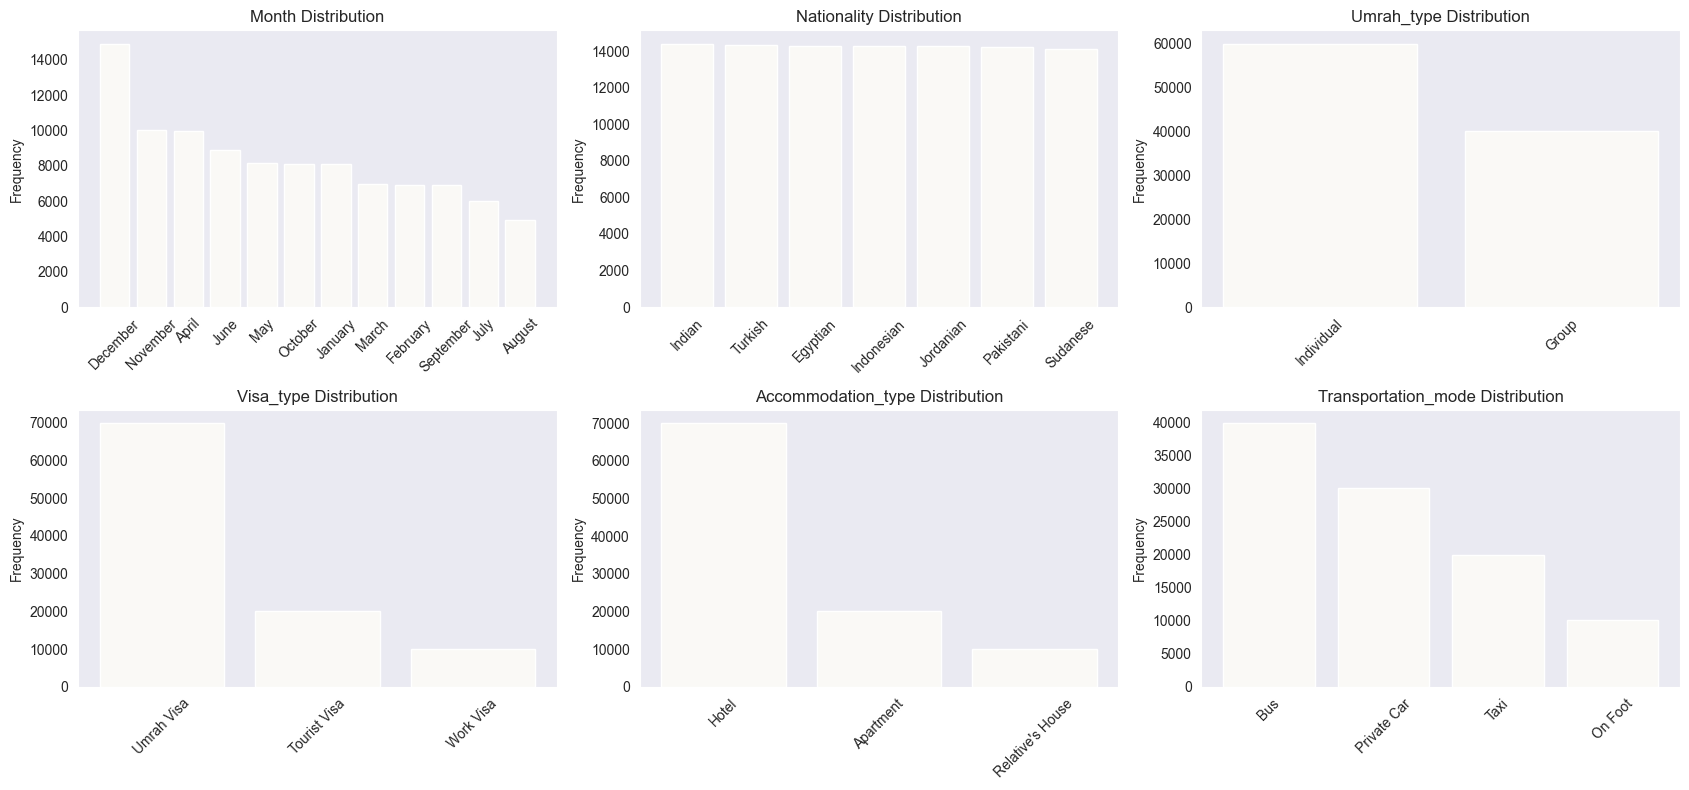

In [22]:
n_cols = 3  
n_rows = math.ceil(len(categorical_columns) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(17, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    value_counts = vistors_df[col].value_counts()
    axes[i].bar(value_counts.index, value_counts.values, color='#FAF9F6')
    axes[i].set_title(f'{col.capitalize()} Distribution')
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis = 'x', rotation = 45)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show() 

In [23]:
# Check Categories Balance 
for col in categorical_columns :
    print(round(vistors_df[col].value_counts() / len(vistors_df[col]), 2) * 100)
    print(" " * 10 )

Month
December     15.0
November     10.0
April        10.0
June          9.0
May           8.0
October       8.0
January       8.0
March         7.0
February      7.0
September     7.0
July          6.0
August        5.0
Name: count, dtype: float64
          
Nationality
Indian        14.0
Turkish       14.0
Egyptian      14.0
Indonesian    14.0
Jordanian     14.0
Pakistani     14.0
Sudanese      14.0
Name: count, dtype: float64
          
Umrah_Type
Individual    60.0
Group         40.0
Name: count, dtype: float64
          
Visa_Type
Umrah Visa      70.0
Tourist Visa    20.0
Work Visa       10.0
Name: count, dtype: float64
          
Accommodation_Type
Hotel               70.0
Apartment           20.0
Relative's House    10.0
Name: count, dtype: float64
          
Transportation_Mode
Bus            40.0
Private Car    30.0
Taxi           20.0
On Foot        10.0
Name: count, dtype: float64
          


In [24]:
# Categorical Resampling Test.

`• Outliers Detection Using ( Isloation Forest ) + ( Boxplot )`

In [25]:
iso_forest_model = IsolationForest(contamination = 0.001, random_state = 42)
outlier_df = vistors_df.copy()
outlier_df['Outlier Flag'] = iso_forest_model.fit_predict(outlier_df.select_dtypes(include = 'number'))
outlier_df = outlier_df[outlier_df['Outlier Flag'] == -1 ]
len(outlier_df)

100

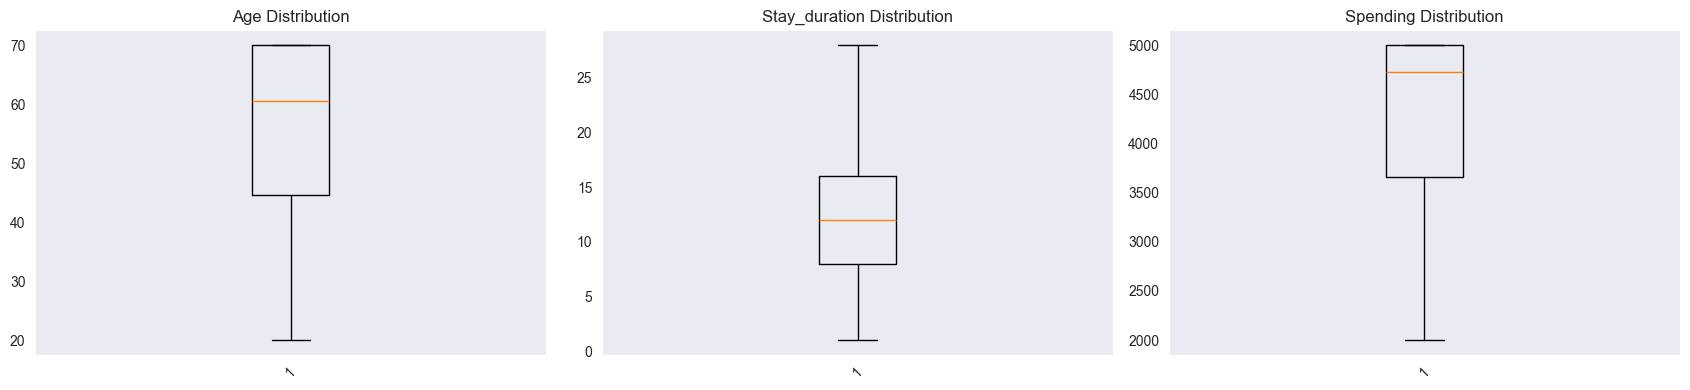

In [26]:
filtered_numeric_columns = [col for col in numeric_columns if col != "Visitor_ID"]
n_cols = 3
n_rows = math.ceil(len(filtered_numeric_columns) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize = (17, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(filtered_numeric_columns) :
    axes[i].boxplot(vistors_df[col])
    axes[i].set_title(f'{col.capitalize()} Distribution')
    axes[i].tick_params(axis='x', rotation = 45)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show() 

In [27]:
def detect_outliers_IQRs(df, column):
    Q1 = np.percentile(df[column], 25)
    Q3 = np.percentile(df[column], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [28]:
for col in filtered_numeric_columns :
    print(detect_outliers_IQRs(vistors_df, col))
    print(' ' * 10) 

Empty DataFrame
Columns: [Visitor_ID, Month, Nationality, Age, Umrah_Type, Stay_Duration, Visa_Type, Accommodation_Type, Transportation_Mode, Spending]
Index: []
          
Empty DataFrame
Columns: [Visitor_ID, Month, Nationality, Age, Umrah_Type, Stay_Duration, Visa_Type, Accommodation_Type, Transportation_Mode, Spending]
Index: []
          
Empty DataFrame
Columns: [Visitor_ID, Month, Nationality, Age, Umrah_Type, Stay_Duration, Visa_Type, Accommodation_Type, Transportation_Mode, Spending]
Index: []
          


<hr/>

#### **Data Preparation & Preprocessing For ML**

• `Data Separation & Spiliting`

In [29]:
features = vistors_df.drop('Spending', axis = 1)
target = vistors_df['Spending']
numeric_features = vistors_df.select_dtypes(include = 'number')
categorical_features = vistors_df.select_dtypes(exclude = 'number')

In [30]:
training_data, testing_data = train_test_split(vistors_df, test_size = 0.3, random_state = 1)

• `Numeric Vs. Target Relation`

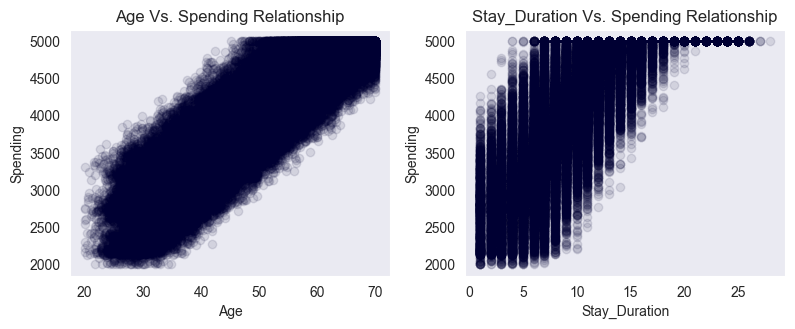

In [31]:
filtered_numeric_columns = [col for col in numeric_columns if col not in ["Visitor_ID", "Spending"]]

n_cols = 3
n_rows = math.ceil(len(numeric_columns) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize = (12, 3 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(filtered_numeric_columns):
    axes[i].scatter(x = vistors_df[feature], y = vistors_df["Spending"], alpha = 0.1, color = '#000033')
    axes[i].set_title(f"{feature} Vs. Spending Relationship")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Spending")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

• `Categorical Vs. Target Relation`

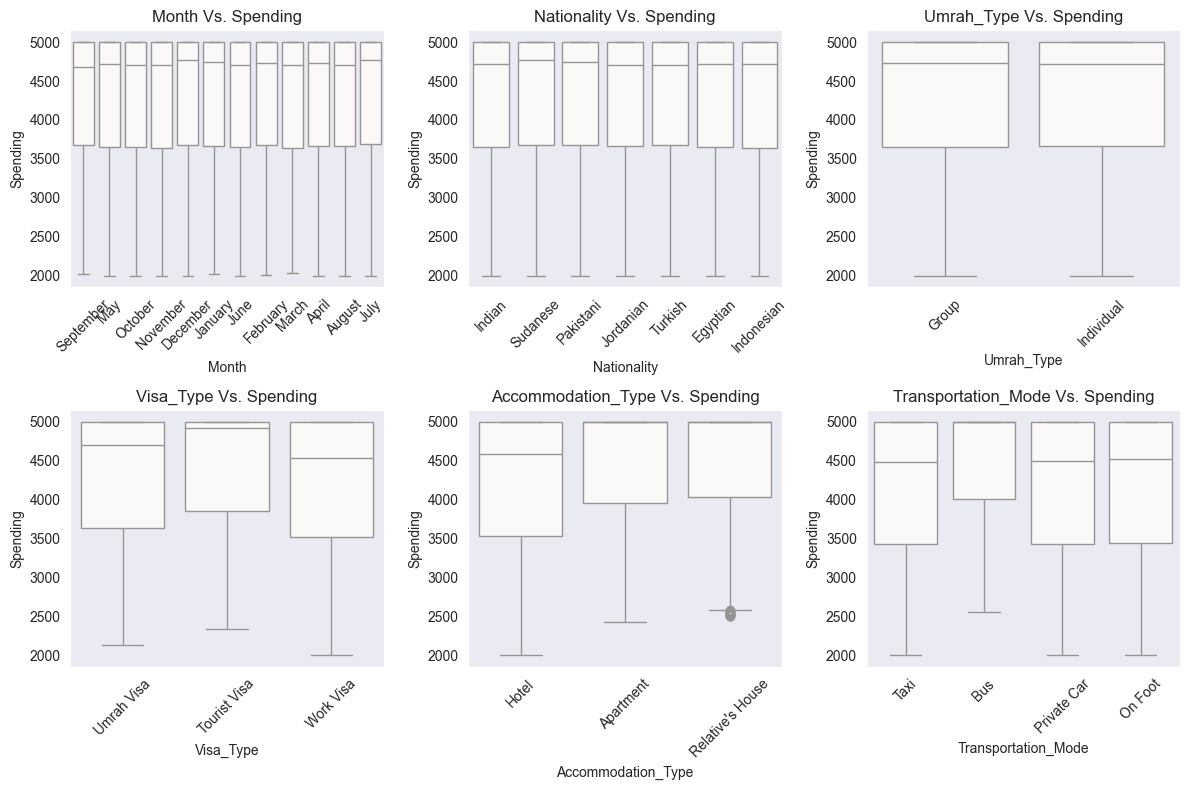

In [32]:
n_cols = 3
n_rows = math.ceil(len(categorical_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()  

for i, feature in enumerate(categorical_columns):
    sns.boxplot(x = vistors_df[feature], y = vistors_df["Spending"], ax = axes[i], color = '#FAF9F6')
    axes[i].set_title(f"{feature} Vs. Spending")
    axes[i].tick_params(axis = 'x', rotation = 45) 

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### **Feature Importance**

• `Risk Ratio`

In [33]:
globel_mean = vistors_df['Spending'].mean()

In [34]:
for feature in categorical_columns :
    globel_mean = vistors_df['Spending'].mean()
    group_df = vistors_df.groupby(by = feature)['Spending'].mean().to_frame(name = 'Mean').reset_index()
    group_df["Difference"] = round((group_df['Mean'] - globel_mean), 3)
    group_df["Risk"] = round((group_df['Mean'] / globel_mean), 4)
    display(group_df)

,Month,Mean,Difference,Risk
0,April,4302.701862,0.741,1.0002
1,August,4304.375895,2.415,1.0006
2,December,4313.872347,11.912,1.0028
3,February,4308.192804,6.232,1.0014
4,January,4306.626024,4.666,1.0011
5,July,4315.178047,13.218,1.0031
6,June,4293.191252,-8.769,0.9980
7,March,4291.756464,-10.204,0.9976
8,May,4299.274321,-2.686,0.9994
9,November,4287.618543,-14.342,0.9967


,Nationality,Mean,Difference,Risk
0,Egyptian,4298.749415,-3.211,0.9993
1,Indian,4297.994079,-3.966,0.9991
2,Indonesian,4295.287462,-6.673,0.9984
3,Jordanian,4296.979500,-4.981,0.9988
4,Pakistani,4308.001190,6.041,1.0014
5,Sudanese,4314.872490,12.912,1.0030
6,Turkish,4302.031154,0.071,1.0000


,Umrah_Type,Mean,Difference,Risk
0,Group,4300.363811,-1.597,0.9996
1,Individual,4303.024478,1.064,1.0002


,Visa_Type,Mean,Difference,Risk
0,Tourist Visa,4399.358982,97.399,1.0226
1,Umrah Visa,4287.085551,-14.875,0.9965
2,Work Visa,4209.732869,-92.228,0.9786


,Accommodation_Type,Mean,Difference,Risk
0,Apartment,4453.713104,151.753,1.0353
1,Hotel,4231.674657,-70.286,0.9837
2,Relative's House,4490.327000,188.367,1.0438


,Transportation_Mode,Mean,Difference,Risk
0,Bus,4483.341518,181.381,1.0422
1,On Foot,4185.519682,-116.441,0.9729
2,Private Car,4180.908350,-121.052,0.9719
3,Taxi,4180.888023,-121.072,0.9719


• `Mutual Information Score`

In [35]:
def calc_mi(feature):
    if is_numeric_dtype(vistors_df[feature]) :
        print(f"Feature '{feature}' isn't categorical")
        return None
    else:
        le = LabelEncoder()
        encoded_feature = le.fit_transform(vistors_df[feature])
        return mutual_info_regression(encoded_feature.reshape(-1, 1), vistors_df['Spending'])[0]

mi_series = pd.Series(
    {feature: calc_mi(feature) for feature in categorical_columns if calc_mi(feature) is not None}
)

mi_series = mi_series.sort_values(ascending = False).to_frame(name = 'MI')
display(mi_series)

,MI
Transportation_Mode,0.273928
Visa_Type,0.107192
Accommodation_Type,0.057294
Umrah_Type,0.000505
Month,0.000000
Nationality,0.000000


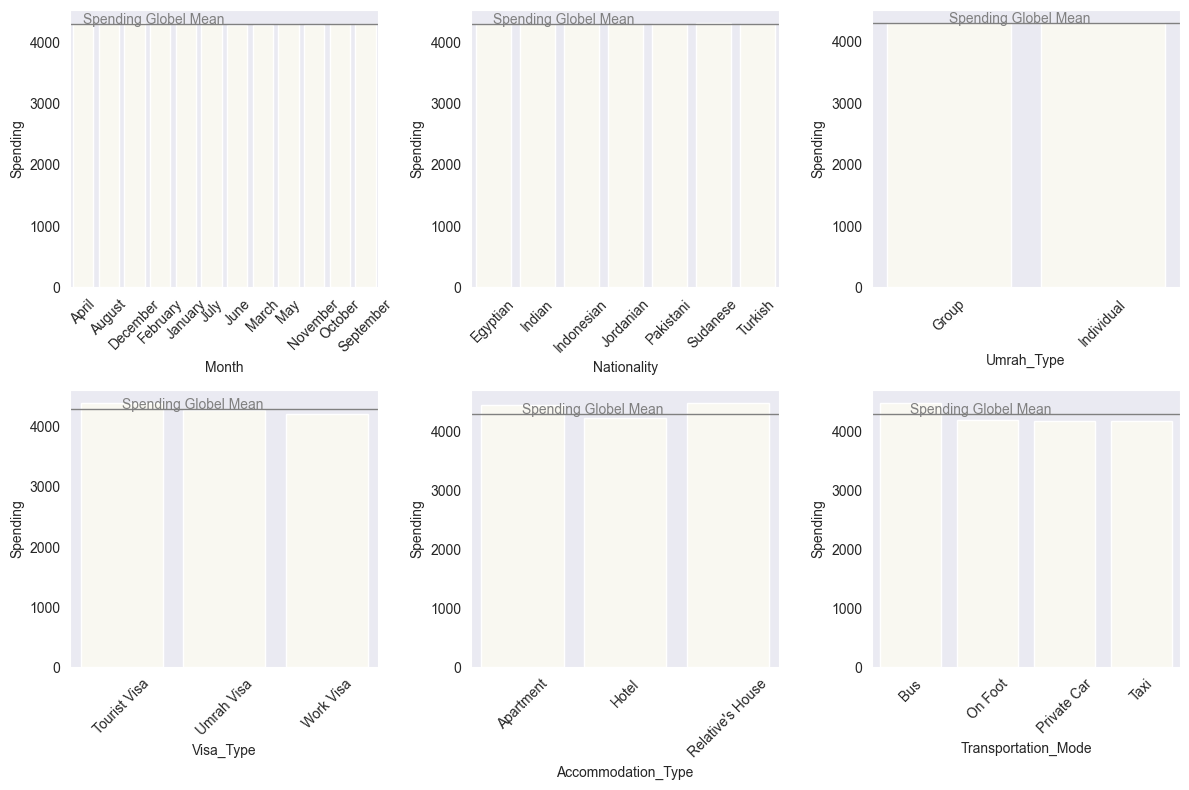

In [36]:
n_cols = 3
n_rows = math.ceil(len(categorical_columns) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(categorical_columns):
    df_group = vistors_df.groupby(by = feature)['Spending'].mean().reset_index()
    sns.barplot(x = feature, y = 'Spending', data = df_group, ax = axes[i], color = "#FAF9F0")
    axes[i].axhline(globel_mean, linewidth = 1, color = 'gray')
    axes[i].text(0, globel_mean - 0.03, "Spending Globel Mean", color = 'gray')
    axes[i].tick_params(axis = 'x', rotation = 45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**NOTE**</br>
Based on the Risk Ratio & Mutual Information Score analysis,</br>
all categorical classes exhibit weak distinguishable variance with the target variable.

• `Numerical Features Vs. Spending Correlation`

In [37]:
corr_features = vistors_df.select_dtypes(include = 'number').drop('Visitor_ID', axis = 1)
df_corr = corr_features.corr()
df_corr

,Age,Stay_Duration,Spending
Age,1.000000,0.876228,0.933919
Stay_Duration,0.876228,1.000000,0.823220
Spending,0.933919,0.823220,1.000000


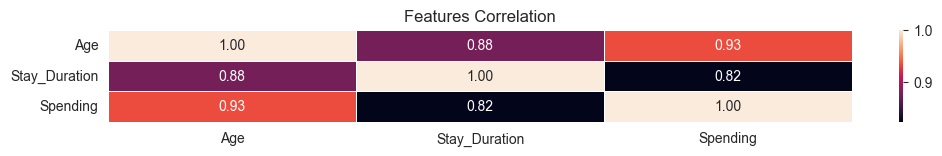

In [38]:
plt.figure(figsize = (12, 1.2))
sns.heatmap(df_corr, annot = True, fmt = '0.2f', linewidths = 0.5)
plt.title("Features Correlation")
plt.show()

In [39]:
numeric_features = [col for col in vistors_df.select_dtypes(include = 'number').columns if col not in ['Spending', "Visitor_ID"]]
df_corr = round(vistors_df[numeric_features].corrwith(vistors_df["Spending"]), 3)
display(df_corr.to_frame(name = "Correlation"))

,Correlation
Age,0.934
Stay_Duration,0.823


#### **Feature Engineering**

In [40]:
vistors_df["Month"].unique()

array(['September', 'May', 'October', 'November', 'December', 'January',
       'June', 'February', 'March', 'April', 'August', 'July'],
      dtype=object)

In [41]:
# Ectract & Building New Features From Old One
season_mapping = {
    "Ramadan": ["March"],
    "Huj": ["April", "May", "June"],
    "Summer": ["July", "August", "September", "October", "November"],
    "Winter": ["December", "January", "February"]
}

In [42]:
def map_season(month) :
    for season, months in season_mapping.items():
        if month in months :
            return season

vistors_df["Season"] = vistors_df["Month"].apply(map_season)

In [43]:
vistors_df.head(2)

,Visitor_ID,Month,Nationality,Age,Umrah_Type,Stay_Duration,Visa_Type,Accommodation_Type,Transportation_Mode,Spending,Season
0,1,September,Indian,70.0,Group,14.0,Umrah Visa,Hotel,Taxi,5000.000000,Summer
1,2,May,Sudanese,28.9,Group,3.0,Umrah Visa,Hotel,Bus,2817.178967,Huj


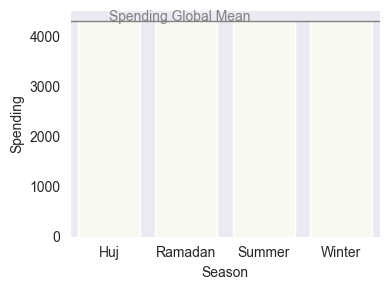

In [44]:
df_group = vistors_df.groupby("Season")['Spending'].mean().reset_index()
fig, ax = plt.subplots(figsize = (4, 3))
sns.barplot(x = "Season", y = 'Spending', data = df_group, ax = ax, color = "#FAF9F0")
ax.axhline(globel_mean, linewidth = 1, color = 'gray')
ax.text(0, globel_mean - 0.03, "Spending Global Mean", color = 'gray')
ax.tick_params(axis = 'x', rotation = 0)

plt.tight_layout()
plt.show()

#### **Feature Selection**

Due To Poor Data Quality, Most Features Are Unsuitable. However, We Will Build The Model Using The Most Relevant And Reliable Features Available.<br/>( **Age - Duration Stay - Umrah Type - Transportation Type - Accomendation Type - Month - Nationality** )

In [45]:
prepared_df = vistors_df.drop(["Visa_Type"], axis = 1)
prepared_df.head(2)

,Visitor_ID,Month,Nationality,Age,Umrah_Type,Stay_Duration,Accommodation_Type,Transportation_Mode,Spending,Season
0,1,September,Indian,70.0,Group,14.0,Hotel,Taxi,5000.000000,Summer
1,2,May,Sudanese,28.9,Group,3.0,Hotel,Bus,2817.178967,Huj


#### **Data Spiliting**

In [46]:
features = prepared_df.drop("Spending", axis = 1)
target = prepared_df["Spending"]

x_train, x_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size = 0.2, 
                                                   shuffle = True, 
                                                   random_state = 42)

#### **Feature Encoding**

In [47]:
one_hot_encoder = OneHotEncoder(sparse_output = False, drop = "first")
encoded_train_data = one_hot_encoder.fit_transform(
    x_train[["Month", "Nationality", "Umrah_Type", "Accommodation_Type", "Transportation_Mode"]])
trained_encoded_df = pd.DataFrame(encoded_train_data, columns = one_hot_encoder.get_feature_names_out(
    ["Month", "Nationality", "Umrah_Type", "Accommodation_Type", "Transportation_Mode"]))

In [48]:
test_encoded = one_hot_encoder.transform(
    x_test[["Month", "Nationality", "Umrah_Type", "Accommodation_Type", "Transportation_Mode"]])
test_encoded_df = pd.DataFrame(test_encoded, columns = one_hot_encoder.get_feature_names_out(
    ["Month", "Nationality", "Umrah_Type", "Accommodation_Type", "Transportation_Mode"]))

#### **Feature Scaling**

In [49]:
sc = StandardScaler()

x_trained_scaled = sc.fit_transform(trained_encoded_df)
x_test_scaled = sc.transform(test_encoded_df)

x_trained_scaled_df = pd.DataFrame(x_trained_scaled, columns = trained_encoded_df.columns, index = x_train.index)
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns = test_encoded_df.columns, index = x_test.index)

display(x_trained_scaled_df.head(3))
display(x_test_scaled_df.head(3))

,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,...,Nationality_Jordanian,Nationality_Pakistani,Nationality_Sudanese,Nationality_Turkish,Umrah_Type_Individual,Accommodation_Type_Hotel,Accommodation_Type_Relative's House,Transportation_Mode_On Foot,Transportation_Mode_Private Car,Transportation_Mode_Taxi
75220,-0.228721,-0.418415,-0.273983,-0.296409,-0.251018,-0.313356,-0.273666,3.348692,-0.333958,-0.297281,...,-0.407152,-0.409174,2.459109,-0.407444,-1.224649,0.656057,-0.330153,-0.333472,-0.657344,-0.499707
48955,-0.228721,-0.418415,-0.273983,-0.296409,-0.251018,-0.313356,-0.273666,-0.298624,-0.333958,-0.297281,...,-0.407152,-0.409174,-0.406651,2.454324,0.816560,0.656057,-0.330153,-0.333472,-0.657344,2.001173
44966,-0.228721,-0.418415,-0.273983,-0.296409,-0.251018,-0.313356,-0.273666,-0.298624,-0.333958,-0.297281,...,-0.407152,-0.409174,-0.406651,-0.407444,0.816560,-1.524258,-0.330153,-0.333472,-0.657344,-0.499707


,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,...,Nationality_Jordanian,Nationality_Pakistani,Nationality_Sudanese,Nationality_Turkish,Umrah_Type_Individual,Accommodation_Type_Hotel,Accommodation_Type_Relative's House,Transportation_Mode_On Foot,Transportation_Mode_Private Car,Transportation_Mode_Taxi
75721,-0.228721,-0.418415,-0.273983,-0.296409,-0.251018,-0.313356,-0.273666,-0.298624,-0.333958,-0.297281,...,-0.407152,2.443950,-0.406651,-0.407444,0.816560,-1.524258,3.028900,-0.333472,-0.657344,2.001173
80184,-0.228721,-0.418415,-0.273983,3.373720,-0.251018,-0.313356,-0.273666,-0.298624,-0.333958,-0.297281,...,-0.407152,-0.409174,-0.406651,-0.407444,-1.224649,0.656057,-0.330153,2.998751,-0.657344,-0.499707
19864,-0.228721,-0.418415,-0.273983,-0.296409,-0.251018,-0.313356,-0.273666,3.348692,-0.333958,-0.297281,...,-0.407152,2.443950,-0.406651,-0.407444,-1.224649,0.656057,-0.330153,-0.333472,-0.657344,-0.499707


#### **Model Building**<br/>
Using These Model And Choose The Best<br/>
`- Linear Regression`<br/>
`- Random Forest Regression`<br/>

In [50]:
classifiers = {
    "Random Forest Regression" : RandomForestRegressor(),
    "Linear Regression" : LinearRegression(),
}

# Cross Validation Step :
cv = KFold(
    n_splits = 5,
    shuffle = True,
    random_state = 42
)

eval_results = {}
for name, model in classifiers.items() :
    cv_scores = cross_val_score(
        model,
        x_trained_scaled_df, y_train,
        cv = cv,
        scoring = 'neg_mean_absolute_percentage_error',
    )
    eval_results[name] = abs(np.mean(cv_scores))    
    print(f"{name} : {eval_results[name]:.4f}")

Random Forest Regression : 0.1908
Linear Regression : 0.1898


In [51]:
# Best Model From Our Testing Models :
lr = LinearRegression()

parameters = {
    "fit_intercept": [True, False],  
    "positive": [True, False]       
}
# Fine Tunining :
grid_search = GridSearchCV(
    lr, 
    param_grid = parameters, 
    cv = 5, 
    n_jobs = -1, 
    verbose = 2
)

In [52]:
grid_search.fit(x_trained_scaled_df, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'fit_intercept': True, 'positive': False}
Best Score: 0.04815299753108575


#### **Model Evaluation**

In [54]:
# Best Estimator :
our_model = grid_search.best_estimator_

prediction = our_model.predict(x_test_scaled_df)

mse = mean_squared_error(y_test, prediction)
rmse = mean_squared_error(y_test, prediction, squared = False)
mae = mean_absolute_error(y_test, prediction)
r2 = r2_score(y_test, prediction)

print(f"Mean Squared Error : {round(mse, 4)}")
print(f"Root Mean Squared Error : {round(rmse, 4)}")
print(f"Mean Absoulte Error : {round(mae, 4)}")
print(f"R Squared Performance : {round(r2, 4)}")

Mean Squared Error : 660783.101
Root Mean Squared Error : 812.8857
Mean Absoulte Error : 700.9626
R Squared Performance : 0.0441


#### **Model Saving**

In [55]:
# Saving Machine Learning Model
with open(r"D:\Umrah Visitors Prediction\umrah_spending_prediction.pkl", "wb") as model_file :
    pickle.dump(our_model, model_file)

In [56]:
# Saving Scaler Model
with open(r"D:\Umrah Visitors Prediction\scaler.pkl", "wb") as scaler_file :
    pickle.dump(sc, scaler_file)